<a href="https://colab.research.google.com/github/nikalitt1/Clementine-Agriculture/blob/main/Clementine_Ag_W_A_S_P_Setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

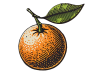

# Clementine Agriculture Tutorial: Training, deployment and setup of scripts for the W.A.S.P and other modules

Welcome!

This tutorial will include:
* Setting up Jetson Orin Nano for deploymeny in Clementine Ag products
*Scripts for product operation, training, and datacollection


First, run the following commands on the Jetson orin nano after initial boot into Jetpack 6.2 in order have all the packages run properly. These setup commands can be found in the following links as well:
* https://docs.luxonis.com/hardware/platform/deploy/to-jetson/
* https://docs.ultralytics.com/guides/nvidia-jetson/#install-ultralytics-package
* https://docs.ultralytics.com/modes/train/#apple-silicon-mps-training


# Step 1: Initial Jetson Orin Nano setup

In [ ]:
sudo apt update && sudo apt upgrade
sudo reboot now

In [ ]:
# Disable ZRAM:
sudo systemctl disable nvzramconfig
# Create 4GB swap file
sudo fallocate -l 4G /mnt/4GB.swap
sudo chmod 600 /mnt/4GB.swap
sudo mkswap /mnt/4GB.swap

In [ ]:
sudo vi /etc/fstab
# Add this line at the bottom of the file
/mnt/4GB.swap swap swap defaults 0 0
# Reboot
sudo reboot now

In [ ]:
sudo wget -qO- https://docs.luxonis.com/install_dependencies.sh | bash

This next step is to start a virtual environment on the Jetson ON, but because this computer will not be used as a general device and is only running the scripts for the W.A.S.P, its not mandatory.

In [ ]:
sudo apt install python3-venv
python3 -m venv depthai
source depthai/bin/activate

In [ ]:
#Clone github repository
git clone https://github.com/luxonis/depthai-python.git
cd depthai-python
python3 examples/install_requirements.py

In [ ]:
echo "export OPENBLAS_CORETYPE=ARMV8" >> ~/.bashrc

Once you have copy and pasted each of these commands into a freshly botted Jetson ON running Jetpack 6.2, the OAK D Lite camera should work when connected to the Jetson ON via USB port.

The next commands should also be run on the Jetson ON, they are the setup commands so that Ultralytics YOLO models can run on the Jetson ON properly.

In [ ]:
sudo apt update
sudo apt install python3-pip -y
pip install -U pip

In [ ]:
pip install ultralytics

In [ ]:
sudo reboot

In [ ]:
pip install https://github.com/ultralytics/assets/releases/download/v0.0.0/torch-2.5.0a0+872d972e41.nv24.08-cp310-cp310-linux_aarch64.whl
pip install https://github.com/ultralytics/assets/releases/download/v0.0.0/torchvision-0.20.0a0+afc54f7-cp310-cp310-linux_aarch64.whl

In [ ]:
wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/arm64/cuda-keyring_1.1-1_all.deb
sudo dpkg -i cuda-keyring_1.1-1_all.deb
sudo apt-get update
sudo apt-get -y install libcusparselt0 libcusparselt-dev

In [ ]:
pip install https://github.com/ultralytics/assets/releases/download/v0.0.0/onnxruntime_gpu-1.20.0-cp310-cp310-linux_aarch64.whl

In [ ]:
pip install numpy==1.23.5

Since numpy will be version 1.23.5 on the Jetson ON, you also need to install that version in this colab to ensure when any training scripts are run in this colab it will use the same version of numpy. If you do not do this the trained model will not work once you transfer it to the Jeton ON. Run the command below in this colab:

In [ ]:
!pip install numpy==1.23.5

# Step 2: Training Ultralytics YOLO11n Model

The annotating and dataset preparation can be done for any model in Roboflow, make sure to export the dataset as a zip file in "YOLO V5 Pytorch format". From here on it will be assumed the dataset is already prepared and saved.

Upload the dataset zip file from roboflow in the side bar, then run the following commands to trin the yolo11n model. make sure to change the file names accordingly, and modify the data.yaml file to match the actual paths to the train, test, and validation paths.

In [ ]:
!unzip -q /content/roboflow_dataset.zip -d /content/dataset/

In [ ]:

!yolo detect train data=data.yaml model=yolo11n.yaml epochs=100 imgsz=640

once run, the model weights can be found in the following file path in the side bar: /yolov5/runs/train/exp/weights/best.pt

you can now send the model weights (best.pt) to the Jetson ON.

Now on the Jetson ON, you cannot directly run the best.pt file, you first need to convert it to a .engine file with the following command, make sure to run this command on the Jetson ON!

In [ ]:
yolo export model=yolo11n.pt format=engine # creates 'yolo11n.engine'

Great, now the object detection setup is done, now its time to train an MLP model to get the W.A.S.P arms to aim accurately at the targets identified by the YOLO11n model.

#Step 3: Training MLP Aiming Model